# CMPINF 2100: Homework 09

## Vedant Kansara

### Assigned: Monday November 15, 2021

### DUE: Tuesday November 23, 2020 at 11:00PM EST

You may add as many code and markdown cells as you see fit to answer the questions.  

**NOTE**: The assignment is due within the Thanksgiving break in case you are traveling over the weekend. You may turn the assignment in by Monday without any penalty. It is a short assignment, and so you should try to complete it by the typical Sunday due date.

#### Write the name of your collaborators here

None.

### Overview

You will consider different types of regularization methods in this assignment. You will fit logistic regression models considering the Ridge and Lasso penalties to understand the influence of the regularization strength on the coefficient estimates. You will also tune the regularization strength with cross-validation.

## Import modules
You will use the following modules in this assignment.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

You will use `statsmodels` and `sklearn` to fit the models. The `statsmodels` formula api, the `dmatrices()` function from `patsy` and the `sklearn` logistic regression method is imported in for you below.

In [2]:
import statsmodels.formula.api as smf
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression

You will tune the regularization in logistic regression using cross-validation. The `sklearn` built-in tuning function is loaded in for you below.

In [3]:
from sklearn.linear_model import LogisticRegressionCV

## Read in data
The training data is read in for you in the cell below. As shown by the `.info()` output, there are 4 continuous inputs `x1` through `x4` and a response `y`. The response is a binary outcome that has already been encoded as 0 and 1 for you, that is why it is an integer data type. A value of 0 represents the non-event, while a value of 1 represents the event. The unique values of `y` are displayed for you to confirm it is a binary variable.

In [4]:
train_url = 'https://raw.githubusercontent.com/jyurko/CMPINF_2100_Fall_2021/main/HW/09/hw09_classify_train.csv'

train_df = pd.read_csv(train_url)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      200 non-null    float64
 1   x2      200 non-null    float64
 2   x3      200 non-null    float64
 3   x4      200 non-null    float64
 4   y       200 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


In [5]:
train_df.y.unique()

array([0, 1], dtype=int64)

## Problem 01

You will start out by fitting a logistic regression model with `statsmodels`.

### 1a)

Fit a logistic regression model with all pair wise interactions between the inputs. Assign the result to the `stats_fit` object.

#### 1a) - SOLUTION

In [6]:
formula_fit = 'y ~ (x1*x2*x3*x4)'

stats_fit =  smf.logit(formula = formula_fit, data=train_df).fit()

Optimization terminated successfully.
         Current function value: 0.498603
         Iterations 8


### 1b)
Display the summary of the for your logistic regression model. How many coefficients were estimated? Which coefficients are statistically significant?

#### 1b) - SOLUTION

In [7]:
print(stats_fit.summary())

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  200
Model:                          Logit   Df Residuals:                      184
Method:                           MLE   Df Model:                           15
Date:                Tue, 23 Nov 2021   Pseudo R-squ.:                  0.2764
Time:                        14:58:23   Log-Likelihood:                -99.721
converged:                       True   LL-Null:                       -137.82
Covariance Type:            nonrobust   LLR p-value:                 3.441e-10
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -0.0589      0.184     -0.320      0.749      -0.419       0.301
x1              0.1457      0.219      0.665      0.506      -0.283       0.575
x2              0.5600      0.255      2.200    

In [8]:
stats_fit.params.nunique()

16

From the summary table we can observe that only the coefficient `x2` coefficient with interaction between `x1:x2`,`x2:x4` are significantly significant.

### 1c)
In addition to displaying the summary report, we have visualized the coefficient estimates and confidence intervals. Visualize the coefficient estimates and confidence for your logistic regression model.  

The previous assignment provided a function to you plot the coefficients. You are allowed to reuse the function from the previous assignment. 

#### 1c) - SOLUTION

In [9]:
def my_coefplot(model_object, figsize_use=(10, 5)):
    fig, ax = plt.subplots(figsize=figsize_use)
    
    ax.errorbar(y = model_object.params.index,
               x = model_object.params,
               fmt = 'o', color = 'black', ecolor='black',
               xerr = 2 * model_object.bse,
               elinewidth = 3, ms=10)
    
    ax.axvline(x = 0, linestyle='--', linewidth=5, color='grey')
    
    ax.set_xlabel('coefficient value')
    
    plt.show()

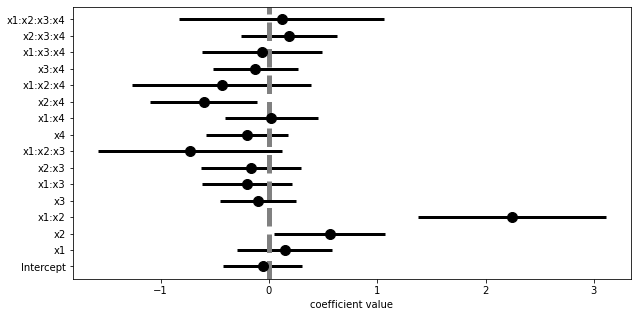

In [10]:
my_coefplot(stats_fit)

### 1d)
A copy of the training data set is created for you below. You will assign predictions of the training set to this copy.

In [11]:
train_copy = train_df.copy()

Predict the training set with your fit logistic regression model. Assign the prediction to a new column in the `train_copy` DataFrame. Name that new column `pred_prob`.

#### 1d) - SOLUTION

In [12]:
train_copy['pred_prob'] = stats_fit.predict(train_copy)

### 1e)
Classify your predictions on the training set assuming a threshold of 0.5. Assign your classifications to the `pred_class` variable in the `train_copy` DataFrame.

#### 1e) - SOLUTION

In [13]:
train_copy['pred_class'] = np.where( train_copy['pred_prob'] > 0.5, 1, 0)

### 1f)
Calculate the Accuracy of your logistic regression model on the training set.

#### 1f) - SOLUTION

In [14]:
train_copy.loc[ train_copy.y == train_copy['pred_class'] ].shape[0] / train_copy.shape[0]

0.72

## Problem 02

You will now fit a logistic regression model with the `sklearn` method `LogisticRegression()`. However, before the model can be fit the we have to assemble the data objects in the correct format. 

### 2a) 
Create the response and input feature array in the format required by `sklearn`. You may use the `dmatrices()` function to create the objects. You should include all pair wise interactions between the inputs, but carefully think through the behavior of the intercept. Assign the response array to `y_sk` and the input feature array to `X_sk`.

#### 2a) - SOLUTION

In [15]:
y_sk, X_sk = dmatrices(formula_fit + '-1', data= train_df)

### 2b)
You will now fit the logistic regression model with `sklearn`. You will **not** use the default settings. Rather, you will set the `penalty` argument equal to `'none'`, you will set the `solver` argument equal to `'lbfgs'`, and you will set the `max_iter` argument to 5001. Assign the fitted model to the `sk_none` object.

#### 2b) - SOLUTION

In [16]:
sk_none = LogisticRegression(penalty='none', solver='lbfgs', max_iter=5001, fit_intercept=True).fit(X_sk, y_sk.ravel())

### 2c)
Display the `sklearn` estimated coefficients to the screen, and do not forget to include the intercept.  

How do the coefficient estimates compare between the `statsmodels` and `sklearn` model fits? Are they similar or are they very different?

#### 2c) - SOLUTION

In [17]:
def extract_sklearn_coefs(sk_mod):
    return list(sk_mod.intercept_.ravel()) + list(sk_mod.coef_.ravel())

In [18]:
extract_sklearn_coefs(sk_none)

[-0.0588689482203567,
 0.1457184088956187,
 0.5600327624714894,
 2.2416025552227383,
 -0.10058548536164022,
 -0.20358860929326453,
 -0.1655115558867452,
 -0.7272661076644187,
 -0.19980661610689598,
 0.021289551557704824,
 -0.6019664978746235,
 -0.4364409757757376,
 -0.1257243275930188,
 -0.06556004071892028,
 0.1858599532380458,
 0.11671693059023688]

In [19]:
pd.DataFrame({'statsmodels': stats_fit.params,
              'sklearn': extract_sklearn_coefs( sk_none)},
             index=stats_fit.params.index)

,statsmodels,sklearn
Intercept,-0.058878,-0.058869
x1,0.145705,0.145718
x2,0.560019,0.560033
x1:x2,2.241473,2.241603
x3,-0.100603,-0.100585
x1:x3,-0.203579,-0.203589
x2:x3,-0.165509,-0.165512
x1:x2:x3,-0.727286,-0.727266
x4,-0.199806,-0.199807
x1:x4,0.021289,0.021290


### 2d)
`sklearn` provides several useful methods for evaluating model performance for us. We do not have to first make predictions and then manually calculate performance metrics, if we are interested in quantities such as Accuracy. The `.score()` method will return the "scoring function" which measures performance. The syntax is:  

`<your model>.score(<input feature array>, <known response array>)`

Accuracy is the default scoring function for logistic regression. Thus, you just need to supply the input feature array as the first argument to the `.score()` method, and the response array as the second argument to the `.score()` method. Behind the scenes, `sklearn` predicts the probability at each input condition, classifies the prediction with the default threshold of 0.5, compares the predicted class to the observed class, and then calculates the fraction of correclty classified observations.

Calculate the accuracy of your `sklearn` fit model. How does the accuracy compare to the accuracy calculated from the `statsmodels` fit?

#### 2d) - SOLUTION

In [20]:
sk_none.score(X_sk, y_sk.ravel())

0.72

## Problem 03
You did not use the default settings when you fit your `sklean` logistic regression model in Problem 02. The default `penalty` argument is `l2` which stands for the L2-norm, and is commonly referred to as the **Ridge penalty**. This problem is focused on studying the behavior of the ridge penalty as you change the inverse of the regularization strength parameter, `C`.

### 3a)
Fit a logistic regression model using the default solver settings. However, you must specify those arguments rather than just relying on the default values, that way we know exactly what was run. Specify the `penalty` argument to be `'l2'`, and set the `C` argument to be equal to `1.0`. You must also set the `solver` argument equal to `'lbfgs'` and set the `max_iter` argument equal to 5001. Assign your fit model to the `sk_default` object.

#### 3a) - SOLUTION

In [21]:
sk_default = LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter = 5001, fit_intercept=True, C=1.0).fit(X_sk, y_sk.ravel())



### 3b)
Display the coefficient estimates for the default logistic regression model. How do they compare to the estimated coefficients when the `penalty` term was set to `'none'`? Don't forget about the intercept!

#### 3b) - SOLUTION

In [22]:
pd.DataFrame({'statsmodels': stats_fit.params,
              'sklearn': extract_sklearn_coefs( sk_none),
               'sklearn_l2': extract_sklearn_coefs(sk_default)},
             index=stats_fit.params.index)

,statsmodels,sklearn,sklearn_l2
Intercept,-0.058878,-0.058869,-0.082598
x1,0.145705,0.145718,0.100582
x2,0.560019,0.560033,0.468322
x1:x2,2.241473,2.241603,1.878686
x3,-0.100603,-0.100585,-0.091436
x1:x3,-0.203579,-0.203589,-0.182673
x2:x3,-0.165509,-0.165512,-0.125884
x1:x2:x3,-0.727286,-0.727266,-0.520707
x4,-0.199806,-0.199807,-0.174707
x1:x4,0.021289,0.021290,0.052878


### 3c)
Calculate the Accuracy on the training set for the model with the default `penalty` and `C` values. 

#### 3c) - SOLUTION

In [23]:
from sklearn.model_selection import KFold

In [24]:
kf05 = KFold(n_splits=5, shuffle=True, random_state=101)

In [25]:
from sklearn.model_selection import cross_val_score

In [26]:
ridge_default_c = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=5001, fit_intercept=False)

accuracy_ridge_default_c = cross_val_score( ridge_default_c, X_sk, y_sk.ravel(), cv=kf05)

print( accuracy_ridge_default_c.mean() )

0.6599999999999999


### 3d)
Next, you change the `C` parameter to a very large value of 10000. Fit the logistic regression model again with this large value of `C` and assign the result to the `sk_large_c` object.

#### 3d) - SOLUTION

In [27]:
sk_large_c = LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter = 5001, fit_intercept=True, C=10000).fit(X_sk, y_sk.ravel())

### 3e)
Display the coefficients for the model with large `C` parameter value. How do they compare to the model with `penalty='none'`?

#### 3e) - SOLUTION

In [28]:
pd.DataFrame({'statsmodels': stats_fit.params,
              'sklearn': extract_sklearn_coefs( sk_none),
               'sklearn_large': extract_sklearn_coefs(sk_large_c)},
             index=stats_fit.params.index)

,statsmodels,sklearn,sklearn_large
Intercept,-0.058878,-0.058869,-0.058872
x1,0.145705,0.145718,0.145712
x2,0.560019,0.560033,0.560019
x1:x2,2.241473,2.241603,2.241549
x3,-0.100603,-0.100585,-0.100584
x1:x3,-0.203579,-0.203589,-0.203586
x2:x3,-0.165509,-0.165512,-0.165506
x1:x2:x3,-0.727286,-0.727266,-0.727233
x4,-0.199806,-0.199807,-0.199803
x1:x4,0.021289,0.021290,0.021294


In [29]:
ridge_large_c = LogisticRegression(penalty='l2', solver='lbfgs', C=10000, max_iter=5001, fit_intercept=True)

accuracy_ridge_large_c = cross_val_score( ridge_large_c, X_sk, y_sk.ravel(), cv=kf05)

print( accuracy_ridge_large_c.mean() )

0.67


### 3f)
Next, reduce `C` to a very small value of 0.0001. Fit the logistic regression model and assign the result to `sk_small_c`.

#### 3f) - SOLUTION

In [30]:
sk_small_c = LogisticRegression(penalty='l2', solver = 'lbfgs', max_iter = 5001, fit_intercept=True, C=0.0001).fit(X_sk, y_sk.ravel())

### 3g)
Display the coefficients for the model with small `C` parameter value. How do the coefficients compare to the model with `penalty='none'`?

#### 3g) - SOLUTION

In [31]:
pd.DataFrame({'statsmodels': stats_fit.params,
              'sklearn': extract_sklearn_coefs( sk_none),
               'sklearn_small': extract_sklearn_coefs(sk_small_c)},
             index=stats_fit.params.index)

,statsmodels,sklearn,sklearn_small
Intercept,-0.058878,-0.058869,-0.180583
x1,0.145705,0.145718,-0.000372
x2,0.560019,0.560033,0.000712
x1:x2,2.241473,2.241603,0.004570
x3,-0.100603,-0.100585,-0.000307
x1:x3,-0.203579,-0.203589,-0.000279
x2:x3,-0.165509,-0.165512,-0.000004
x1:x2:x3,-0.727286,-0.727266,-0.000245
x4,-0.199806,-0.199807,-0.000721
x1:x4,0.021289,0.021290,0.001345


### 3h) 
Calculate the Accuracy for the model with small `C` parameter value. How does the Accuracy compare to the other models you have fit?

#### 3h) - SOLUTION

In [32]:
ridge_small_c = LogisticRegression(penalty='l2', solver='lbfgs', C=0.0001, max_iter=5001, fit_intercept=True)

accuracy_ridge_small_c = cross_val_score( ridge_small_c, X_sk, y_sk.ravel(), cv=kf05)

print( accuracy_ridge_small_c.mean() )

0.545


### 3i)
Describe the impact of the `C` parameter on the coefficient behavior. What happens to the coefficients when `C` is large compared to when `C` is very small.

#### 3i) - SOLUTION

What do you think?

When `C` is large the accuracy increses a little but to **67%** but when `c` is small the accuracy drops ti just **54.5%**.

## Problem 04
The logistic regression function in `sklearn` includes 2 other types of penalties besides the Ridge penalty. You will work with the `penalty='l1'` option in this question, which corresponds to the L1-norm or the **Lasso penalty**. The syntax is similar to the previous question, except that you must change the `solver` argument as well. 

You must specify the `penalty` argument to be `'l1'` and specify the `solver` argument to be `'saga'` for all parts in this question.

### 4a)
Fit a logistic regression model with the lasso penalty with the `C` parameter set to 1. Assign the result to the `sk_lasso_default` object.

#### 4a) - SOLUTION

In [33]:
sk_lasso_default = LogisticRegression(penalty='l1', solver='saga', max_iter=5001, fit_intercept=True, C=1.0).\
fit(X_sk, y_sk.ravel())

### 4b)
Fit a logistic regression model with the lasso penalty with the `C` parameter set to a large value of 10000. Assign the result to the `sk_lasso_large_c` object.

#### 4b) - SOLUTION

In [34]:
sk_lasso_large_c = LogisticRegression(penalty='l1', solver='saga', max_iter=5001, fit_intercept=True, C=10000).\
fit(X_sk, y_sk.ravel())

### 4c)
Fit a logistic regression model with the lasso penalty with the `C` parameter set to a very small value of 0.0001. Assign the result to the `sk_lasso_small_c` object.

#### 4c) - SOLUTION

In [35]:
sk_lasso_small_c = LogisticRegression(penalty='l1', solver='saga', max_iter=5001, fit_intercept=True, C=0.0001).\
fit(X_sk, y_sk.ravel())

### 4d)
Display the coefficient estimates for the 3 different lasso models, `sk_lasso_default`, `sk_lasso_large_c`, and `sk_lasso_small_c` to the screen. What's going on with the coefficient estimates? How are they changing as the value of `C` changes?

#### 4d) - SOLUTION

In [36]:
pd.DataFrame({'statsmodels': stats_fit.params,
              'default': extract_sklearn_coefs( sk_lasso_default),
               'large_c': extract_sklearn_coefs(sk_lasso_large_c),
             'small_c': extract_sklearn_coefs(sk_lasso_small_c)},
             index=stats_fit.params.index)

,statsmodels,default,large_c,small_c
Intercept,-0.058878,-0.095581,-0.059364,-0.098584
x1,0.145705,0.036624,0.144804,0.000000
x2,0.560019,0.423590,0.558458,0.000000
x1:x2,2.241473,1.927859,2.235808,0.000000
x3,-0.100603,-0.069726,-0.100406,0.000000
x1:x3,-0.203579,-0.155680,-0.203501,0.000000
x2:x3,-0.165509,-0.062214,-0.164561,0.000000
x1:x2:x3,-0.727286,-0.406430,-0.722587,0.000000
x4,-0.199806,-0.149296,-0.199371,0.000000
x1:x4,0.021289,0.017333,0.021879,0.000000


### 4e)
Calculate the Accuracy associated the 3 different lasso models and display the results to the screen. Describe the behavior of the model performance as `C` changes.

#### 4e) - SOLUTION

In [37]:
lasso_default_c = LogisticRegression(penalty='l1', solver='saga', C=1.0, max_iter=5001, fit_intercept=True)

lasso_large_c = LogisticRegression(penalty='l1', solver='saga', C=10000, max_iter=5001, fit_intercept=True)

lasso_small_c = LogisticRegression(penalty='l1', solver='saga', C=0.0001, max_iter=5001, fit_intercept=True)

In [38]:
test_accuracy_lasso_default_c = cross_val_score( lasso_default_c, X_sk, y_sk.ravel(), cv=kf05)

In [39]:
test_accuracy_lasso_large_c = cross_val_score( lasso_large_c, X_sk, y_sk.ravel(), cv=kf05)

In [40]:
test_accuracy_lasso_small_c = cross_val_score( lasso_small_c, X_sk, y_sk.ravel(), cv=kf05)

In [41]:
print( test_accuracy_lasso_large_c.mean() )

print( test_accuracy_lasso_default_c.mean() )

print( test_accuracy_lasso_small_c.mean() )

0.67
0.675
0.5349999999999999


### 4f)
How are the coefficients different as the `C` parameter changes when you use the Lasso compared to the Ridge penalty?

#### 4f) - SOLUTION

In ridge the as `C` gets smaller the coefficients becomes closer to zero but they are never exactly zero.

In Lasso as `c` gets smalls the coefficient becomes zero if the coefficient doesn't metter.

## Problem 05
The previous questions focused on studying the model behavior as the `C` parameter is changed. In this problem you will tune or optimize the `C` parameter using cross-validation. You are allowed to the built-in cross-validation function `LogisticRegressionCV()` to perform the cross-validation. 

### 5a)

Tune the `C` parameter using 10 fold cross-validation for the Ridge Penalty. Assign the result to the `ridge_cv` object.

#### 5a) - SOLUTION

In [42]:
from sklearn.linear_model import LogisticRegressionCV

In [43]:
kf10 = KFold(n_splits=10, shuffle=True, random_state=101)

In [44]:
ridge_cv = LogisticRegressionCV(penalty='l2', Cs=101, cv=kf10, solver='lbfgs', max_iter=5001, fit_intercept=True).\
fit(X_sk, y_sk.ravel())

### 5b)
What is the optimal `C` value?

#### 5b) - SOLUTION

In [45]:
ridge_cv.C_

array([0.06309573])

### 5c)
Display the coefficients associated with the optimal `C` value. How do they compare to the logistic regression model fit with `penalty='none'`?

#### 5c) - SOLUTION

In [46]:
pd.DataFrame({'statsmodels': stats_fit.params,
              'sk_none': extract_sklearn_coefs(sk_none),
              'ridge_best': extract_sklearn_coefs(ridge_cv)},
            index=stats_fit.params.index)

,statsmodels,sk_none,ridge_best
Intercept,-0.058878,-0.058869,-0.149066
x1,0.145705,0.145718,0.005149
x2,0.560019,0.560033,0.214793
x1:x2,2.241473,2.241603,0.862227
x3,-0.100603,-0.100585,-0.061636
x1:x3,-0.203579,-0.203589,-0.081773
x2:x3,-0.165509,-0.165512,-0.035314
x1:x2:x3,-0.727286,-0.727266,-0.142439
x4,-0.199806,-0.199807,-0.098530
x1:x4,0.021289,0.021290,0.102834


### 5d)
Tune the `C` parameter using 10 fold cross-validation for the Lasso Penalty. Assign the result to the `lasso_cv` object.

#### 5d) - SOLUTION

In [47]:
lasso_cv = LogisticRegressionCV(penalty='l1', Cs=101, cv=kf10, solver='saga', max_iter=5001, fit_intercept=True).\
fit(X_sk, y_sk.ravel())

### 5e)
What is the optimal `C` value associated with the lasso model?

#### 5e) - SOLUTION

In [48]:
lasso_cv.C_

array([0.06309573])

### 5f)
Display the coefficients associated with the optimal `C` value for the lasso model. What has your model "turned into"?

#### 5f) - SOLUTION

In [49]:
pd.DataFrame({'statsmodels': stats_fit.params,
              'sk_none': extract_sklearn_coefs(sk_none),
              'lasso_best': extract_sklearn_coefs(lasso_cv)},
            index=stats_fit.params.index)

,statsmodels,sk_none,lasso_best
Intercept,-0.058878,-0.058869,-0.184136
x1,0.145705,0.145718,0.000000
x2,0.560019,0.560033,0.000000
x1:x2,2.241473,2.241603,0.798613
x3,-0.100603,-0.100585,0.000000
x1:x3,-0.203579,-0.203589,0.000000
x2:x3,-0.165509,-0.165512,0.000000
x1:x2:x3,-0.727286,-0.727266,0.000000
x4,-0.199806,-0.199807,0.000000
x1:x4,0.021289,0.021290,0.000000


The model has turned into just the interaction betweem `x1:x2` and zeroed all other variables